# **Sistema de Recomendação**
* Vinícius de Moraes 
* Bruno Ideriha Sugahara 
* Raul Ribeiro Teles 

Referências:

http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/

https://towardsdatascience.com/music-artist-recommender-system-using-stochastic-gradient-descent-machine-learning-from-scratch-5f2f1aae972c

https://heartbeat.comet.ml/recommender-systems-with-python-part-iii-collaborative-filtering-singular-value-decomposition-5b5dcb3f242b

Sistemas de recomendação são sistemas que sugerem itens como produtos, filmes, músicas ou pessoas para usuários de determinada aplicação. Eles ajudam a fazer escolhas melhores, encontrar conteúdos relevantes e a economizar tempo, sendo amplamente utilizados em grandes empresas.

Há dois tipos principais de sistemas de recomendação:

*   Content based - foca nas propriedades dos itens e recomenda caso sejam semelhantes
*   Colaborative filtering (CF) - faz previsões baseado no comportamento de outros usuários com perfil semelhante

Vamos usar o colaborative filtering com um modelo de fatoração de matriz para realizar a previsão e testar em um dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## **Importando Bibliotecas**

In [ ]:
#Bibliotecas Utilizadas
import numpy as np
import pandas as pd
import random
import matplotlib as plt
from google.colab import drive

## **1) Importando o Dataset do Google Drive**

> **Nesta fase, importamos os seguintes datasets:**
> * **Anime: Um dataset que contêm 12.294 animes que estão listados no site [MyAnimeList](https://myanimelist.net)**
> * **Rating: Um dataset que contém a lista individual de 73.516 usuários diferentes com suas respectivas notas**
> * **Listas: um conjunto de 13 listas de usuários voluntários que foram adquiridos a partir de um [formulário do google](https://forms.gle/8K3hJQx6HtmBXqXZA)**

In [ ]:
drive.mount('/content/drive/')

In [ ]:
PATH = 'drive/MyDrive/alglin'

In [ ]:
%%time
!unzip -qq $PATH/archive.zip
!unzip -qq $PATH/listas.zip

## **2) Pré-processamento do Dataframe**

> **Nesta fase, realizamos o tratamento e o pré-processamento do nosso conjunto de dados**
> * **1) As listas dos usuários voluntários foram tratadas para que elas seguissem o padrão do dataset de rating**
> * **2) Foram escolhidos apenas os primeiros 500 usuários do dataset de ratings. Esse número foi escolhido após uma série de testes e essa quantidade de usuários apresentou uma maior variedade de recomendações em uma quantidade razoável de tempo**
> * **3) Os dados foram organizados em uma matriz (usuários)x(animes) onde os valores são as notas individuais de cada usuário para cada anime**
> * **4) O número "-1" que antes representava os animes que determinado usuário assistiu, mas não deu nenhuma nota foram substituídos por *NaN* (Not a Number)**

In [ ]:
anime_data = pd.read_csv('anime.csv')
rating_data = pd.read_csv('rating.csv')

In [ ]:
def adicionar_myanimelist(path, id):
  if '.xml' in path:
    myanimelist = pd.read_xml(path)
  else:
    myanimelist = pd.read_csv(path)
  myanimeswatched = myanimelist['series_title']
  myanimeswatched = myanimeswatched.str.lower()
  myanimeswatched = list(myanimeswatched)
  myanimelist = myanimelist[['my_id','series_animedb_id', 'my_score']]
  myanimelist = myanimelist.rename(columns = {'my_id':'user_id', 'series_animedb_id':'anime_id', 'my_score':'rating'})
  for i in range (len(myanimelist)):
    elem = myanimelist.iloc[i]
    if elem['rating'] == 0:
      myanimelist.at[i, 'rating'] = -1
  for i in range (len(myanimelist)):
    elem = myanimelist.iloc[i]
    myanimelist.at[i, 'user_id'] = id
  return myanimeswatched, myanimelist

In [ ]:
myanimeswatched_boemio, myanimelist_boemio = adicionar_myanimelist('/content/Boemio.csv',0)
myanimeswatched_roxy, myanimelist_roxy = adicionar_myanimelist('/content/MyAngelROxy.csv',-1)
myanimeswatched_vpn, myanimelist_vpn = adicionar_myanimelist('/content/Jo╞o Victor.xml',-2)
myanimeswatched_ange, myanimelist_ange = adicionar_myanimelist('/content/Ange.xml',-3)
myanimeswatched_adryan, myanimelist_adryan = adicionar_myanimelist('/content/Adryan.xml',-4)
myanimeswatched_kayke, myanimelist_kayke = adicionar_myanimelist('/content/Kayke.xml',-5)
myanimeswatched_leonardo, myanimelist_leonardo = adicionar_myanimelist('/content/Leonardo da Silva.xml',-6)
myanimeswatched_mardiodidi, myanimelist_mardiodidi = adicionar_myanimelist('/content/Mardiodidi.xml',-7)
myanimeswatched_matheus, myanimelist_matheus = adicionar_myanimelist('/content/Matheus Oliveira.xml',-8)
myanimeswatched_neko, myanimelist_neko = adicionar_myanimelist('/content/Neko Ushio.xml',-9)
myanimeswatched_nekocat, myanimelist_nekocat = adicionar_myanimelist('/content/Nekocat.xml',-10)
myanimeswatched_victor, myanimelist_victor = adicionar_myanimelist('/content/Victor Santos.xml',-11)
myanimeswatched_bic, myanimelist_bic = adicionar_myanimelist('/content/Bic.xml',-12)


rating_data = rating_data.append(myanimelist_boemio)
rating_data = rating_data.append(myanimelist_roxy)
rating_data = rating_data.append(myanimelist_ange)
rating_data = rating_data.append(myanimelist_adryan)
rating_data = rating_data.append(myanimelist_kayke)
rating_data = rating_data.append(myanimelist_leonardo)
rating_data = rating_data.append(myanimelist_mardiodidi)
rating_data = rating_data.append(myanimelist_matheus)
rating_data = rating_data.append(myanimelist_neko)
rating_data = rating_data.append(myanimelist_nekocat)
rating_data = rating_data.append(myanimelist_victor)
rating_data = rating_data.append(myanimelist_bic)

In [ ]:
animes_por_usuario = rating_data['user_id'].value_counts()

In [ ]:
df = rating_data.merge(anime_data, left_on = 'anime_id', right_on = 'anime_id', suffixes= ['_user', ''])
df = df[['user_id', 'name', 'rating_user']]

In [ ]:
df_mini = df[df['user_id'] < 500]
df_mini.sort_values('user_id')
df_mini

In [ ]:
matriz = df_mini.pivot_table(index=['user_id'], columns=['name'], values='rating_user')

In [ ]:
column_headers = list(matriz.columns.values)
for i in range(len(column_headers)):
  column_headers[i] = column_headers[i].lower()

In [ ]:
matriz_R = matriz.to_numpy()
matriz_R[matriz_R == -1] = None
matriz_R

## **3) Algorítmo do Sistema de Recomendação (Fatorização de Matriz)**
**A fatorização de matriz é um método que permite identificar as matrizes que, multiplicadas, resultam em uma matriz original definida anteriormente. No caso do CF, essa matriz original é a matriz R que representa as notas que usuários deram para determinados itens. A partir dela, é possível descobrir uma matriz P que associa usuários a características e uma matriz Q que associa itens a características.**

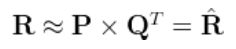

**O produto interno dessas matrizes resulta em uma matriz com as notas previstas dos usuários para cada um dos itens:**

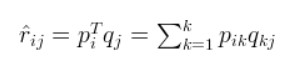

**Para que a previsão seja precisa é necessário minimizar a diferença entre os valores da matriz resultante e da matriz original, ou seja, o erro:**

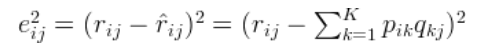

**Para isso, será utilizado o Método do Gradiente (Gradient descent), no qual após inicializar as matrizes P e Q com valores aleatórios, são realizadas iterações para diminuir o erro até encontrar um minimo local.**

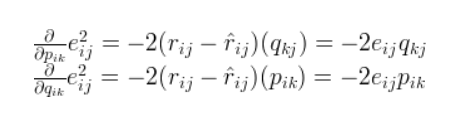

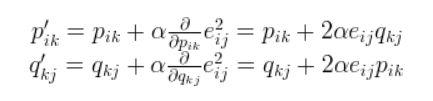

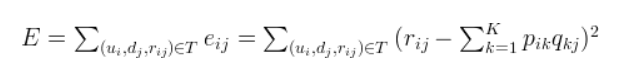

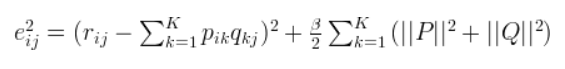

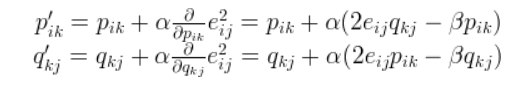

In [ ]:
def matrix_factorization(R, P, Q, K, iteracoes=500, alfa=0.0002, beta=0.02):

#    R: matriz de resultados
#    P: |U| * K (matriz de características do usuário)
#    Q: |D| * K (matriz de características do item)
#    K: características latentes
#    alfa: taxa de aprendizado
#    beta: parâmetro de regularização

  # Transpondo matriz
    Q = Q.T

    for step in range(iteracoes):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    # Cálculo do erro
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])

                    for k in range(K):
                        # Cálculo do gradiente
                        P[i][k] = P[i][k] + alfa * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alfa * (2 * eij * P[i][k] - beta * Q[k][j])

        # Produto interno
        eR = np.dot(P,Q)

        e = 0

        for i in range(len(R)):

            for j in range(len(R[i])):

                if R[i][j] > 0:

                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)

                    for k in range(K):

                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        # 0.001: mínimo local
        if e < 0.001:

            break

    return P, Q.T

In [ ]:
# N: número de usuários
N = len(matriz_R)
# M: número de itens
M = len(matriz_R[0])
# K: número de características
K = 5

 
P = np.random.rand(N,K)
Q = np.random.rand(M,K)

 

nP, nQ = matrix_factorization(matriz_R, P, Q, K)

nR = np.dot(nP, nQ.T)
nR
df_nR = pd.DataFrame(nR)
df_nR

,0,1,2,3,4,5,6,7,8,9,...,4574,4575,4576,4577,4578,4579,4580,4581,4582,4583
0,6.935464,8.297762,8.879418,4.204289,5.709888,4.683213,5.434760,6.213058,5.316220,6.064610,...,4.734540,1.984635,5.688349,7.034664,5.225653,6.108966,6.834472,6.925594,5.545135,2.702047
1,6.827171,8.918890,10.935385,3.627100,6.333210,4.330744,6.182500,6.632215,4.723415,5.417181,...,4.132358,1.537034,5.675335,6.705054,4.298346,5.003736,6.441463,7.279801,4.957320,2.374212
2,8.899547,10.136757,11.036417,6.860735,8.119659,7.178008,7.194760,7.463811,7.263648,7.391716,...,6.297423,2.717353,8.122902,8.883599,8.123864,8.455706,8.106260,9.290891,7.686321,4.347999
3,8.116225,8.726889,9.960553,5.251250,6.576692,7.024966,6.461678,8.145111,6.638728,7.146154,...,5.856034,2.918562,6.748094,8.785273,5.254174,7.032589,8.498108,7.384589,7.564278,3.176661
4,7.453029,7.821328,7.441081,6.287635,6.475992,6.566254,5.557998,5.917274,6.585987,6.490503,...,5.720877,2.769456,6.965028,7.751420,7.488393,7.882574,7.074032,7.547968,7.165805,3.893924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506,8.160379,9.040140,9.729747,6.351293,6.954562,6.476819,6.157426,6.752962,6.703183,7.087447,...,5.902132,2.414309,7.142580,8.040632,7.529614,7.961465,7.416423,8.094258,6.827281,4.079874
507,8.081653,8.783307,8.716811,6.680976,7.559369,7.234217,6.553001,6.623317,7.044513,6.682162,...,6.023320,3.045275,7.838926,8.503844,7.862082,8.198634,7.684292,8.603684,7.951418,4.080739
508,6.580599,6.022005,6.202610,6.491023,7.462482,8.899407,6.482960,6.365725,6.649331,4.700047,...,5.329169,3.904105,7.772926,8.150839,5.997890,6.702163,6.990444,7.312966,9.229321,3.491730
509,2.820552,2.925402,2.589610,2.549029,2.453539,2.467847,2.015632,2.040670,2.546962,2.478012,...,2.212639,1.042319,2.691993,2.879192,3.157334,3.167630,2.584870,2.911020,2.700350,1.594658


## **4) Recomendações aos Usuários**

> **Nesta fase, mostramos em uma tabela os 10 animes não assistidos pelos usuários que o Sistema de Recomendação julgou que seriam melhor avaliados por eles**

> **De acordo com o próprio site de onde tiramos as avaliações, as notas são definidas como:**
> * **10 - Obra-prima**
> * **9 - Ótimo**
> * **8 - Muito bom**
> * **7 - Bom**
> * **6 - Ok**
> * **5 - Mediano**
> * **4 - Ruim**
> * **3 - Muito ruim**
> * **2 - Horrível**
> * **1 - Terrível**


In [ ]:
recomendados = []
mean_score = []
animes_assistidos = []

**Lista de recomendados do usuário: Boemio**

In [ ]:
lista_recomendados_boemio = []
nota_prevista_boemio = []
for i in range(len(nR[12])):
  elem = nR[12][i]
  if elem >= 8 and not (column_headers[i] in myanimeswatched_boemio):
    lista_recomendados_boemio.append(column_headers[i])
    nota_prevista_boemio.append(nR[12][i])

mean_score_boemio = myanimelist_boemio[myanimelist_boemio['rating'] > 0].mean()

recomendados.append(len(lista_recomendados_boemio))
mean_score.append(mean_score_boemio['rating'])
animes_assistidos.append(len(myanimelist_boemio))

data = {'Nome do Anime': lista_recomendados_boemio, 'Score': nota_prevista_boemio}
df_recomendados_boemio = pd.DataFrame(data=data)
df_recomendados_boemio = df_recomendados_boemio.sort_values('Score', ascending = False)
df_recomendados_boemio = df_recomendados_boemio.reset_index()
df_recomendados_boemio.drop(columns = 'index', inplace=True)
df_recomendados_boemio.head(10)

,Nome do Anime,Score
0,je t&#039;aime,13.990433
1,senki zesshou symphogear 5th season,12.740292
2,"wake up, girls! seishun no kage",12.270107
3,gintama: dai hanseikai,12.214482
4,zettai shounen,12.214011
5,dennou coil,12.185412
6,saenai heroine no sodatekata ♭,12.065324
7,muumindani no suisei,12.010748
8,maison ikkoku,11.994239
9,yu☆gi☆oh! arc-v,11.963063


**Lista de recomendados do usuário: Roxy**

In [ ]:
lista_recomendados_roxy = []
nota_prevista_roxy = []

for i in range(len(nR[11])):
  elem = nR[11][i]
  if elem >= 8 and not (column_headers[i] in myanimeswatched_roxy):
    lista_recomendados_roxy.append(column_headers[i])
    nota_prevista_roxy.append(nR[11][i])

mean_score_roxy = myanimelist_roxy[myanimelist_roxy['rating'] > 0].mean()

recomendados.append(len(lista_recomendados_roxy))
mean_score.append(mean_score_roxy['rating'])
animes_assistidos.append(len(myanimelist_roxy))

data = {'Nome do Anime': lista_recomendados_roxy, 'Score': nota_prevista_roxy}
df_recomendados_roxy = pd.DataFrame(data=data)
df_recomendados_roxy = df_recomendados_roxy.sort_values('Score', ascending = False)
df_recomendados_roxy = df_recomendados_roxy.reset_index()
df_recomendados_roxy.drop(columns = 'index', inplace=True)
df_recomendados_roxy.head(10)

,Nome do Anime,Score
0,rurouni kenshin: meiji kenkaku romantan - tsui...,10.446895
1,the idolm@ster,10.286720
2,gintama movie: kanketsu-hen - yorozuya yo eien...,10.217572
3,baccano!,10.192392
4,bakuman. 3rd season,10.159876
5,owarimonogatari,9.993675
6,yojouhan shinwa taikei,9.899343
7,neon genesis evangelion: the end of evangelion,9.878384
8,durarara!! specials,9.749890
9,aria the origination,9.723881


**Listas de recomendados: Joãovpp**

In [ ]:
lista_recomendados_vpn = []
nota_prevista_vpn = []

for i in range(len(nR[10])):
  elem = nR[10][i]
  if elem >= 8 and not (column_headers[i] in myanimeswatched_vpn):
    lista_recomendados_vpn.append(column_headers[i])
    nota_prevista_vpn.append(nR[10][i])

mean_score_vpn = myanimelist_vpn[myanimelist_vpn['rating'] > 0].mean()

recomendados.append(len(lista_recomendados_vpn))
mean_score.append(mean_score_vpn['rating'])
animes_assistidos.append(len(myanimelist_vpn))

data = {'Nome do Anime': lista_recomendados_vpn, 'Score': nota_prevista_vpn}
df_recomendados_vpn = pd.DataFrame(data=data)
df_recomendados_vpn = df_recomendados_vpn.sort_values('Score', ascending = False)
df_recomendados_vpn = df_recomendados_vpn.reset_index()
df_recomendados_vpn.drop(columns = 'index', inplace=True)
df_recomendados_vpn.head(10)

,Nome do Anime,Score
0,senki zesshou symphogear 5th season,9.837738
1,gintama movie: kanketsu-hen - yorozuya yo eien...,9.409143
2,aria the origination,9.398860
3,"wake up, girls! seishun no kage",9.336368
4,rurouni kenshin: meiji kenkaku romantan - tsui...,9.307682
5,baccano!,9.277608
6,muumindani no suisei,9.237960
7,ginga tetsudou no yoru,9.229588
8,girls und panzer der film,9.184565
9,cross game,9.113856


**Listas de recomendados: Ange**

In [ ]:
lista_recomendados_ange = []
nota_prevista_ange = []

for i in range(len(nR[9])):
  elem = nR[9][i]
  if elem >= 8 and not (column_headers[i] in myanimeswatched_ange):
    lista_recomendados_ange.append(column_headers[i])
    nota_prevista_ange.append(nR[9][i])

mean_score_ange = myanimelist_ange[myanimelist_ange['rating'] > 0].mean()

recomendados.append(len(lista_recomendados_ange))
mean_score.append(mean_score_ange['rating'])
animes_assistidos.append(len(myanimelist_ange))

data = {'Nome do Anime': lista_recomendados_ange, 'Score': nota_prevista_ange}
df_recomendados_ange = pd.DataFrame(data=data)
df_recomendados_ange = df_recomendados_ange.sort_values('Score', ascending = False)
df_recomendados_ange = df_recomendados_ange.reset_index()
df_recomendados_ange.drop(columns = 'index', inplace=True)
df_recomendados_ange.head(10)

,Nome do Anime,Score
0,je t&#039;aime,10.015250
1,senki zesshou symphogear 5th season,8.900768
2,gintama&#039;,8.836417
3,muumindani no suisei,8.827344
4,gintama&#039;: enchousen,8.806963
5,hibike! euphonium 2,8.783797
6,uchuu kyoudai,8.560950
7,gintama: dai hanseikai,8.523047
8,shoujo kakumei utena,8.512292
9,hunter x hunter (2011),8.460093


**Listas de recomendados: Adryan**

In [ ]:
lista_recomendados_adryan = []
nota_prevista_adryan = []

for i in range(len(nR[8])):
  elem = nR[8][i]
  if elem >= 8 and not (column_headers[i] in myanimeswatched_adryan):
    lista_recomendados_adryan.append(column_headers[i])
    nota_prevista_adryan.append(nR[8][i])

mean_score_adryan = myanimelist_adryan[myanimelist_adryan['rating'] > 0].mean()

recomendados.append(len(lista_recomendados_adryan))
mean_score.append(mean_score_adryan['rating'])
animes_assistidos.append(len(myanimelist_adryan))

data = {'Nome do Anime': lista_recomendados_adryan, 'Score': nota_prevista_adryan}
df_recomendados_adryan = pd.DataFrame(data=data)
df_recomendados_adryan = df_recomendados_adryan.sort_values('Score', ascending = False)
df_recomendados_adryan = df_recomendados_adryan.reset_index()
df_recomendados_adryan.drop(columns = 'index', inplace=True)
df_recomendados_adryan.head(10)

,Nome do Anime,Score
0,senki zesshou symphogear 5th season,11.963150
1,je t&#039;aime,11.814281
2,gintama: dai hanseikai,11.429803
3,muumindani no suisei,11.378825
4,ginga tetsudou no yoru,11.295787
5,yu☆gi☆oh! arc-v,11.236399
6,saenai heroine no sodatekata ♭,11.087996
7,gintama,11.007958
8,one piece,10.989528
9,uchuu kyoudai,10.950204


**Listas de recomendados: Kayke**

In [ ]:
lista_recomendados_kayke = []
nota_prevista_kayke = []

for i in range(len(nR[7])):
  elem = nR[7][i]
  if elem >= 8 and not (column_headers[i] in myanimeswatched_kayke):
    lista_recomendados_kayke.append(column_headers[i])
    nota_prevista_kayke.append(nR[7][i])

mean_score_kayke = myanimelist_kayke[myanimelist_kayke['rating'] > 0].mean()

recomendados.append(len(lista_recomendados_kayke))
mean_score.append(mean_score_kayke['rating'])
animes_assistidos.append(len(myanimelist_kayke))

data = {'Nome do Anime': lista_recomendados_kayke, 'Score': nota_prevista_kayke}
df_recomendados_kayke = pd.DataFrame(data=data)
df_recomendados_kayke = df_recomendados_kayke.sort_values('Score', ascending = False)
df_recomendados_kayke = df_recomendados_kayke.reset_index()
df_recomendados_kayke.drop(columns = 'index', inplace=True)
df_recomendados_kayke.head(10)

,Nome do Anime,Score
0,neon genesis evangelion: the end of evangelion,10.570673
1,clannad,10.363378
2,nichijou,10.057669
3,kill la kill,10.048722
4,kuroko no basket 2nd season,10.006795
5,senki zesshou symphogear 5th season,9.983497
6,clannad: after story,9.848442
7,wolf&#039;s rain ova,9.817726
8,aria the origination,9.814398
9,muumindani no suisei,9.749156


**Listas de recomendados: Leonardo**

In [ ]:
lista_recomendados_leonardo = []
nota_prevista_leonardo = []

for i in range(len(nR[6])):
  elem = nR[6][i]
  if elem >= 8 and not (column_headers[i] in myanimeswatched_leonardo):
    lista_recomendados_leonardo.append(column_headers[i])
    nota_prevista_leonardo.append(nR[6][i])

mean_score_leonardo = myanimelist_leonardo[myanimelist_leonardo['rating'] > 0].mean()

recomendados.append(len(lista_recomendados_leonardo))
mean_score.append(mean_score_leonardo['rating'])
animes_assistidos.append(len(myanimelist_leonardo))

data = {'Nome do Anime': lista_recomendados_leonardo, 'Score': nota_prevista_leonardo}
df_recomendados_leonardo = pd.DataFrame(data=data)
df_recomendados_leonardo = df_recomendados_leonardo.sort_values('Score', ascending = False)
df_recomendados_leonardo = df_recomendados_leonardo.reset_index()
df_recomendados_leonardo.drop(columns = 'index', inplace=True)
df_recomendados_leonardo.head(10)

,Nome do Anime,Score
0,senki zesshou symphogear 5th season,9.253536
1,je t&#039;aime,9.097310
2,anime tenchou x touhou project,8.975811
3,haiyore! nyaruko-san f,8.786824
4,"wake up, girls! seishun no kage",8.751991
5,yu☆gi☆oh! arc-v,8.560693
6,gintama: dai hanseikai,8.459665
7,girls und panzer der film,8.401821
8,cross game,8.393231
9,kizumonogatari iii: reiketsu-hen,8.377360


**Listas de recomendados: Mardiodidi**

In [ ]:
lista_recomendados_mardiodidi = []
nota_prevista_mardiodidi = []

for i in range(len(nR[5])):
  elem = nR[5][i]
  if elem >= 8 and not (column_headers[i] in myanimeswatched_mardiodidi):
    lista_recomendados_mardiodidi.append(column_headers[i])
    nota_prevista_mardiodidi.append(nR[5][i])

mean_score_mardiodidi = myanimelist_mardiodidi[myanimelist_mardiodidi['rating'] > 0].mean()

recomendados.append(len(lista_recomendados_mardiodidi))
mean_score.append(mean_score_mardiodidi['rating'])
animes_assistidos.append(len(myanimelist_mardiodidi))

data = {'Nome do Anime': lista_recomendados_mardiodidi, 'Score': nota_prevista_mardiodidi}
df_recomendados_mardiodidi = pd.DataFrame(data=data)
df_recomendados_mardiodidi = df_recomendados_mardiodidi.sort_values('Score', ascending = False)
df_recomendados_mardiodidi = df_recomendados_mardiodidi.reset_index()
df_recomendados_mardiodidi.drop(columns = 'index', inplace=True)
df_recomendados_mardiodidi.head(10)

,Nome do Anime,Score
0,je t&#039;aime,10.675175
1,senki zesshou symphogear 5th season,10.510773
2,"wake up, girls! seishun no kage",10.027435
3,anime tenchou x touhou project,9.822992
4,muumindani no suisei,9.776488
5,zettai shounen,9.701534
6,gintama: dai hanseikai,9.602669
7,haiyore! nyaruko-san f,9.557915
8,girls und panzer der film,9.555798
9,saenai heroine no sodatekata ♭,9.492582


**Listas de recomendados: Matheus**

In [ ]:
lista_recomendados_matheus = []
nota_prevista_matheus = []

for i in range(len(nR[4])):
  elem = nR[4][i]
  if elem >= 8 and not (column_headers[i] in myanimeswatched_matheus):
    lista_recomendados_matheus.append(column_headers[i])
    nota_prevista_matheus.append(nR[4][i])

mean_score_matheus = myanimelist_matheus[myanimelist_matheus['rating'] > 0].mean()

recomendados.append(len(lista_recomendados_matheus))
mean_score.append(mean_score_matheus['rating'])
animes_assistidos.append(len(myanimelist_matheus))

data = {'Nome do Anime': lista_recomendados_matheus, 'Score': nota_prevista_matheus}
df_recomendados_matheus = pd.DataFrame(data=data)
df_recomendados_matheus = df_recomendados_matheus.sort_values('Score', ascending = False)
df_recomendados_matheus = df_recomendados_matheus.reset_index()
df_recomendados_matheus.drop(columns = 'index', inplace=True)
df_recomendados_matheus.head(10)

,Nome do Anime,Score
0,je t&#039;aime,10.762509
1,senki zesshou symphogear 5th season,10.394818
2,"wake up, girls! seishun no kage",9.845714
3,gintama: dai hanseikai,9.778794
4,muumindani no suisei,9.722849
5,saenai heroine no sodatekata ♭,9.655730
6,yu☆gi☆oh! arc-v,9.627588
7,zettai shounen,9.597516
8,anime tenchou x touhou project,9.585672
9,haiyore! nyaruko-san f,9.573209


**Listas de recomendados: Neko Ushio**

In [ ]:
lista_recomendados_neko = []
nota_prevista_neko = []

for i in range(len(nR[3])):
  elem = nR[3][i]
  if elem >= 8 and not (column_headers[i] in myanimeswatched_neko):
    lista_recomendados_neko.append(column_headers[i])
    nota_prevista_neko.append(nR[3][i])

mean_score_neko = myanimelist_neko[myanimelist_neko['rating'] > 0].mean()

recomendados.append(len(lista_recomendados_neko))
mean_score.append(mean_score_neko['rating'])
animes_assistidos.append(len(myanimelist_neko))

data = {'Nome do Anime': lista_recomendados_neko, 'Score': nota_prevista_neko}
df_recomendados_neko = pd.DataFrame(data=data)
df_recomendados_neko = df_recomendados_neko.sort_values('Score', ascending = False)
df_recomendados_neko = df_recomendados_neko.reset_index()
df_recomendados_neko.drop(columns = 'index', inplace=True)
df_recomendados_neko.head(10)

,Nome do Anime,Score
0,aria the origination,11.037487
1,baccano!,11.027731
2,gintama movie: kanketsu-hen - yorozuya yo eien...,10.870392
3,ginga tetsudou no yoru,10.805457
4,senki zesshou symphogear 5th season,10.654900
5,bakuman. 3rd season,10.612186
6,yojouhan shinwa taikei,10.394403
7,zoku natsume yuujinchou: 3d nyanko-sensei gekijou,10.298048
8,muumindani no suisei,10.289369
9,uchuu kyoudai,10.279422


**Listas de recomendados: Nekocat**

In [ ]:
lista_recomendados_nekocat = []
nota_prevista_nekocat = []

for i in range(len(nR[2])):
  elem = nR[2][i]
  if elem >= 8 and not (column_headers[i] in myanimeswatched_nekocat):
    lista_recomendados_nekocat.append(column_headers[i])
    nota_prevista_nekocat.append(nR[2][i])

mean_score_nekocat = myanimelist_nekocat[myanimelist_nekocat['rating'] > 0].mean()

recomendados.append(len(lista_recomendados_nekocat))
mean_score.append(mean_score_nekocat['rating'])
animes_assistidos.append(len(myanimelist_nekocat))

data = {'Nome do Anime': lista_recomendados_nekocat, 'Score': nota_prevista_nekocat}
df_recomendados_nekocat = pd.DataFrame(data=data)
df_recomendados_nekocat = df_recomendados_nekocat.sort_values('Score', ascending = False)
df_recomendados_nekocat = df_recomendados_nekocat.reset_index()
df_recomendados_nekocat.drop(columns = 'index', inplace=True)
df_recomendados_nekocat.head(10)

,Nome do Anime,Score
0,je t&#039;aime,13.040388
1,senki zesshou symphogear 5th season,12.089978
2,gintama&#039;: enchousen,11.680001
3,muumindani no suisei,11.679975
4,gintama,11.655892
5,gintama&#039;,11.603387
6,one piece,11.566703
7,uchuu kyoudai,11.346031
8,shoujo kakumei utena,11.339758
9,kimi no na wa.,11.236179


**Listas de recomendados: Victor**

In [ ]:
lista_recomendados_victor = []
nota_prevista_victor = []

for i in range(len(nR[1])):
  elem = nR[1][i]
  if elem >= 8 and not (column_headers[i] in myanimeswatched_victor):
    lista_recomendados_victor.append(column_headers[i])
    nota_prevista_victor.append(nR[1][i])

mean_score_victor = myanimelist_victor[myanimelist_victor['rating'] > 0].mean()

recomendados.append(len(lista_recomendados_victor))
mean_score.append(mean_score_victor['rating'])
animes_assistidos.append(len(myanimelist_victor))

data = {'Nome do Anime': lista_recomendados_victor, 'Score': nota_prevista_victor}
df_recomendados_victor = pd.DataFrame(data=data)
df_recomendados_victor = df_recomendados_victor.sort_values('Score', ascending = False)
df_recomendados_victor = df_recomendados_victor.reset_index()
df_recomendados_victor.drop(columns = 'index', inplace=True)
df_recomendados_victor.head(10)

,Nome do Anime,Score
0,&quot;bungaku shoujo&quot; movie,10.935385
1,gintama&#039;,10.477336
2,gintama&#039;: enchousen,10.105547
3,ergo proxy,9.827285
4,gintama movie: kanketsu-hen - yorozuya yo eien...,9.725584
5,uchuu kyoudai,9.507224
6,tengen toppa gurren lagann movie: lagann-hen,9.354237
7,je t&#039;aime,9.336897
8,break blade 5: shisen no hate,9.290620
9,berserk,9.257014


**Lista de recomendados: Victorina**

In [ ]:
lista_recomendados_bic = []
nota_prevista_bic = []

for i in range(len(nR[0])):
  elem = nR[0][i]
  if elem >= 8 and not (column_headers[i] in myanimeswatched_bic):
    lista_recomendados_bic.append(column_headers[i])
    nota_prevista_bic.append(nR[0][i])

mean_score_bic = myanimelist_bic[myanimelist_bic['rating'] > 0].mean()

recomendados.append(len(lista_recomendados_bic))
mean_score.append(mean_score_bic['rating'])
animes_assistidos.append(len(myanimelist_bic))

data = {'Nome do Anime': lista_recomendados_bic, 'Score': nota_prevista_bic}
df_recomendados_bic = pd.DataFrame(data=data)
df_recomendados_bic = df_recomendados_bic.sort_values('Score', ascending = False)
df_recomendados_bic = df_recomendados_bic.reset_index()
df_recomendados_bic.drop(columns = 'index', inplace=True)
df_recomendados_bic.head(10)

,Nome do Anime,Score
0,gintama,9.456773
1,gintama&#039;,9.448506
2,gintama movie: kanketsu-hen - yorozuya yo eien...,9.295005
3,je t&#039;aime,9.078410
4,aria the origination,9.049131
5,gintama&#039;: enchousen,9.016818
6,hunter x hunter (2011),9.015805
7,&quot;bungaku shoujo&quot; movie,8.879418
8,muumindani no suisei,8.812625
9,fullmetal alchemist: brotherhood,8.795982


## **5) Análise dos Resultados**
> **Por fim, fizemos uma breve análise dos resultados gerados pelo Sistema de Recomendação**
> * **Gráfico de Correlação entre a quantidade de animes assistidos, a nota média e a quantidade de animes que foram recomendados ao usuário**
> * **Tabela mostrando quais foram os animes que o algoritmo mais recomendou para as pessoas**

**Relação entre animes assistidos, a média de notas do usuário e a quantidade de animes que foram recomendados**

In [ ]:
data = {'Animes Assistidos': animes_assistidos, 'Mean Score': mean_score, 'Animes Recomendados': recomendados}
relacao_score_recomendados = pd.DataFrame(data=data)
relacao_score_recomendados

,Animes Assistidos,Mean Score,Animes Recomendados
0,389,6.049505,2409
1,130,7.434109,175
2,951,7.488677,153
3,756,6.257447,38
4,389,8.517588,1422
5,477,7.175732,374
6,346,6.411371,28
7,93,7.630769,305
8,237,6.798742,262
9,550,7.289474,494


In [ ]:
corr = relacao_score_recomendados.corr()
corr.style.background_gradient(cmap='coolwarm')

,Animes Assistidos,Mean Score,Animes Recomendados
Animes Assistidos,1.000000,-0.532865,-0.346963
Mean Score,-0.532865,1.000000,0.282076
Animes Recomendados,-0.346963,0.282076,1.000000


**Animes que o algorítmo mais recomendou para os usuários**

In [ ]:
df_mean = df_nR.mean(axis=0)
df_mean = df_mean.sort_values(ascending=False)
lista_recomendados_geral = []
nota_prevista_geral = []

for i in range(len(df_mean)):
  elem = df_mean[i]
  if elem >= 7.5:
    lista_recomendados_geral.append(column_headers[i])
    nota_prevista_geral.append(elem)

In [ ]:
data = {'Nome do Anime': lista_recomendados_geral, 'Score': nota_prevista_geral}
df_recomendados_geral = pd.DataFrame(data=data)
df_recomendados_geral = df_recomendados_geral.sort_values('Score', ascending = False)
df_recomendados_geral = df_recomendados_geral.reset_index()
df_recomendados_geral.drop(columns = 'index', inplace=True)
df_recomendados_geral.head(10)

,Nome do Anime,Score
0,je t&#039;aime,11.246328
1,senki zesshou symphogear 5th season,10.726162
2,"wake up, girls! seishun no kage",10.278642
3,anime tenchou x touhou project,10.085587
4,zettai shounen,10.041656
5,muumindani no suisei,9.974161
6,gintama: dai hanseikai,9.956769
7,saenai heroine no sodatekata ♭,9.878721
8,haiyore! nyaruko-san f,9.852046
9,yu☆gi☆oh! arc-v,9.840328
